In [1]:
import time

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch import nn
import matplotlib.pyplot as plt


In [2]:
# 利用Dataset类构建训练集
train_data = datasets.MNIST("./MNIST_dataset", train=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])]), download=True)

# 利用Dataset类构建测试集b
test_data = datasets.MNIST("./MNIST_dataset", train=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])]), download=True)

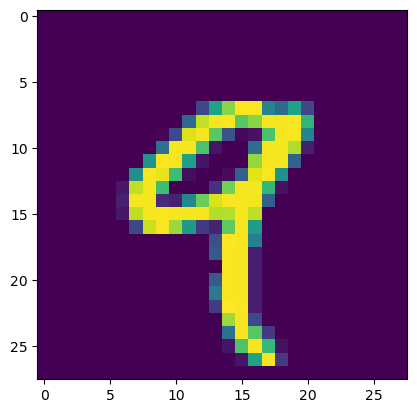

9


In [3]:
# 测试数据集的可用性

img, label = train_data[4]
img = img.numpy().transpose(1, 2, 0)
plt.imshow(img)
plt.show()
print(label)

In [4]:
# 变量定义

batch_size = 256
train_data_size = len(train_data)
test_data_size = len(test_data)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

writer = SummaryWriter("MNIST_logs")

In [5]:
# 神经网络搭建
class MNIST_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 20, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(80, 20),
            nn.ReLU(),
            # nn.Linear(64, 20),
            # nn.ReLU(),
            nn.Linear(20, 10)
        )

    def forward(self, x):
        return self.model(x)


# 用于处理feature的hook函数
class HookTool:
    def __init__(self):
        self.fea = None

    def hook_fun(self, module, fea_in, fea_out):
        '''
        注意用于处理feature的hook函数必须包含三个参数[module, fea_in, fea_out]，参数的名字可以自己起，但其意义是
        固定的，第一个参数表示torch里的一个子module，比如Linear,Conv2d等，第二个参数是该module的输入，其类型是
        tuple；第三个参数是该module的输出，其类型是tensor。注意输入和输出的类型是不一样的，切记。
        '''
        self.fea = fea_out

def get_feas_by_hook(model):
    """
    提取Conv2d后的feature，我们需要遍历模型的module，然后找到Conv2d，把hook函数注册到这个module上；
    这就相当于告诉模型，我要在Conv2d这一层，用hook_fun处理该层输出的feature.
    由于一个模型中可能有多个Conv2d，所以我们要用hook_feas存储下来每一个Conv2d后的feature
    """
    fea_hooks = []
    for n, m in model.named_modules():
        if isinstance(m, torch.nn.MaxPool2d):
            cur_hook = HookTool()
            m.register_forward_hook(cur_hook.hook_fun)
            fea_hooks.append(cur_hook)

    return fea_hooks


In [6]:
net = MNIST_net()
print(net)
x = torch.randn([256, 1, 28, 28])
fea_hooks = get_feas_by_hook(net)
out = net(x)
print('The number of hooks is:', len(fea_hooks))
for i in range(len(fea_hooks)):
    print(f'The shape of the {i+1} Conv2d feature is:', fea_hooks[i].fea.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if(torch.cuda.is_available()):
    net = net.to(device)

MNIST_net(
  (model): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 20, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=80, out_features=20, bias=True)
    (11): ReLU()
    (12): Linear(in_features=20, out_features=10, bias=True)
  )
)
The number of hooks is: 3
The shape of the 1 Conv2d feature is: torch.Size([256, 6, 14, 14])
The shape of the 2 Conv2d feature is: torch.Size([256, 16, 7, 7])
The shape of the 3 Conv2d feature is: torch.Size([256, 20, 2, 2])


In [8]:
learning_rate = 0.002
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(net.parameters(), lr=learning_rate)
epoch = 10
total_train_step = 0
total_test_step = 0
step = 0
start_time = time.time()
for i in range(epoch):
    print(f"-------------第{i + 1}轮训练开始------------")
    total_running_loss = 0
    step = 0
    for data in train_dataloader:
        imgs, labels = data
        if (torch.cuda.is_available()):
            imgs = imgs.to(device)
            labels = labels.to(device)
        output = net(imgs)
        loss = loss_fn(output, labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        total_train_step += 1
        step += 1
        total_running_loss += loss
        if step % 100 == 0:
            end_time = time.time()
            print(f"第{step}/{train_data_size // batch_size}步训练： Loss:{loss} 时间：{end_time - start_time}")
            writer.add_scalar("train_loss", loss.item(), total_train_step)

    print(f"第{i + 1}轮训练平均损失:{total_running_loss / (train_data_size / batch_size)}")
    total_test_loss = 0
    total_correct_num = 0
    total_accuracy = 0
    with torch.no_grad():
        for data in test_dataloader:
            imgs, labels = data
            if (torch.cuda.is_available()):
                imgs = imgs.to(device)
                labels = labels.to(device)
            output = net(imgs)
            loss = loss_fn(output, labels)
            total_test_loss += loss
            total_correct_num += (output.argmax(1) == labels).sum()


    total_accuracy = total_correct_num / test_data_size
    print(f"整体测试集损失为:{total_test_loss}")
    print(f"整体测试集正确率为:{total_accuracy}")
    writer.add_scalar("test_loss", total_test_loss, total_test_step)
    writer.add_scalar("test_accuracy", total_accuracy, total_test_step)
    total_test_step += 1



writer.close()

-------------第1轮训练开始------------
第100/234步训练： Loss:0.29208171367645264 时间：7.46974515914917
第200/234步训练： Loss:0.14860495924949646 时间：11.537485122680664
第1轮训练平均损失:0.5890215635299683
整体测试集损失为:6.3175554275512695
整体测试集正确率为:0.9462999701499939
-------------第2轮训练开始------------
第100/234步训练： Loss:0.16363349556922913 时间：17.832884311676025
第200/234步训练： Loss:0.05160970985889435 时间：21.375827074050903
第2轮训练平均损失:0.12562799453735352
整体测试集损失为:3.640005588531494
整体测试集正确率为:0.9682999849319458
-------------第3轮训练开始------------
第100/234步训练： Loss:0.05372177064418793 时间：27.485269784927368
第200/234步训练： Loss:0.07710392773151398 时间：30.69276785850525
第3轮训练平均损失:0.08513591438531876
整体测试集损失为:2.400620222091675
整体测试集正确率为:0.9787999987602234
-------------第4轮训练开始------------
第100/234步训练： Loss:0.08975907415151596 时间：36.60400104522705
第200/234步训练： Loss:0.09290478378534317 时间：40.47622060775757
第4轮训练平均损失:0.0672721341252327
整体测试集损失为:2.555290937423706
整体测试集正确率为:0.9769999980926514
-------------第5轮训练开始------------
第100/234步训练： Loss

[](./MNIST_dataset/)